# 1. Modeling and Evaluation: HR Employee Attrition

**Objective:** Train a baseline model to predict employee attrition.  
**Goal:** Establish a performant model (not overfitted) to serve as the base for XAI analysis.

**References:**

- [Kaggle Dataset Link](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)


In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Add src to system path to import custom modules
sys.path.append(os.path.abspath(os.path.join("..")))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Import custom plotting functions from src/
from src.evaluation_plots import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_class_distribution,
)

## 2. Data Loading and Exploration


In [2]:
# Load Data
# Ensure the dataset is downloaded to the data/ folder
df = pd.read_csv("../data/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Quick Look
print(f"Dataset Shape: {df.shape}")
display(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2



Missing Values:
0


### Target Distribution

We need to check if the dataset is imbalanced, as this affects our metric choice (Accuracy vs F1-Score).


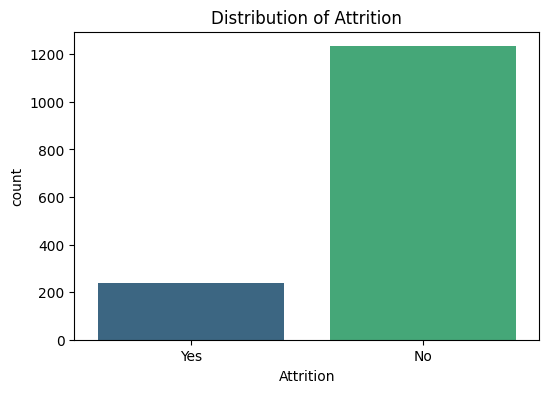

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


In [3]:
plot_class_distribution(df, "Attrition")
print(df["Attrition"].value_counts(normalize=True))

**Observation:** The dataset is imbalanced (~84% No, ~16% Yes). We must use **F1-Score** and **ROC-AUC** for evaluation, not just accuracy.


### Feature Distribution


In [4]:
# print YearsAtCompany distribution
print("\nYearsAtCompany Distribution:")
print(df["YearsAtCompany"].value_counts().to_dict())


YearsAtCompany Distribution:
{5: 196, 1: 171, 3: 128, 2: 127, 10: 120, 4: 110, 7: 90, 9: 82, 8: 80, 6: 76, 0: 44, 11: 32, 20: 27, 13: 24, 15: 20, 14: 18, 22: 15, 21: 14, 12: 14, 18: 13, 16: 12, 19: 11, 17: 9, 24: 6, 33: 5, 26: 4, 25: 4, 31: 3, 32: 3, 27: 2, 29: 2, 36: 2, 23: 2, 37: 1, 40: 1, 34: 1, 30: 1}


In [5]:
# Print feature distribution of values with value counts
for column in df.columns:
    vc = df[column].value_counts()
    # print(vc.index)
    if len(vc.index) < 2:
        print(f"\nFeature: {column}")
        print(vc.to_dict())


Feature: EmployeeCount
{1: 1470}

Feature: Over18
{'Y': 1470}

Feature: StandardHours
{80: 1470}


## 3. Preprocessing

1.  **Drop irrelevant columns**: `EmployeeCount`, `Over18`, `StandardHours` (contain only 1 unique value).
2.  **Encode Categoricals**:
    - `Attrition` (Target) -> 0/1
    - Categorical Features -> One-Hot Encoding (using `get_dummies` for simplicity in this baseline).


In [6]:
# 1. Drop useless columns
df_clean = df.drop(
    ["EmployeeCount", "Over18", "StandardHours", "EmployeeNumber"], axis=1
)

# 2. Encode Target
le = LabelEncoder()
df_clean["Attrition"] = le.fit_transform(df_clean["Attrition"])  # Yes=1, No=0

# 3. Encode Features (One-Hot)
# We separate X (features) and y (target) first
X = df_clean.drop("Attrition", axis=1)
y = df_clean["Attrition"]

# Identify categorical columns for encoding
categorical_cols = X.select_dtypes(include=["object"]).columns
print(f"Categorical Columns to Encode: {list(categorical_cols)}")

# Apply One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Final Feature Count: {X_encoded.shape[1]}")

Categorical Columns to Encode: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Final Feature Count: 44


## 4. Train/Test Split

We use a standard 80/20 split with stratification to maintain class proportions.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training shapes: {X_train.shape}")
print(f"Testing shapes:  {X_test.shape}")

Training shapes: (1176, 44)
Testing shapes:  (294, 44)


## 5. Model Training

We use a **Random Forest Classifier**.

- **Why?** It handles tabular data well, handles non-linearities, and provides built-in feature importance (useful for global XAI).
- **Settings:** `class_weight='balanced'` is used to help with the class imbalance identified earlier.


In [29]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,  # Limit depth to prevent overfitting
    random_state=42,
    class_weight="balanced",
)

rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6. Evaluation


In [78]:
# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[
    :, 1
]  # Probability for positive class (Attrition=Yes)

# Metrics
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.82      0.87       247
           1       0.39      0.60      0.47        47

    accuracy                           0.79       294
   macro avg       0.65      0.71      0.67       294
weighted avg       0.83      0.79      0.80       294

Accuracy Score: 0.7857


### Visualizing Performance

We look at the Confusion Matrix to see false negatives (people we missed who actually left) and ROC Curve.


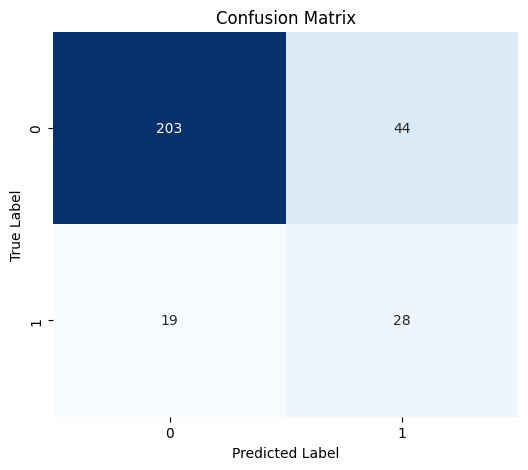

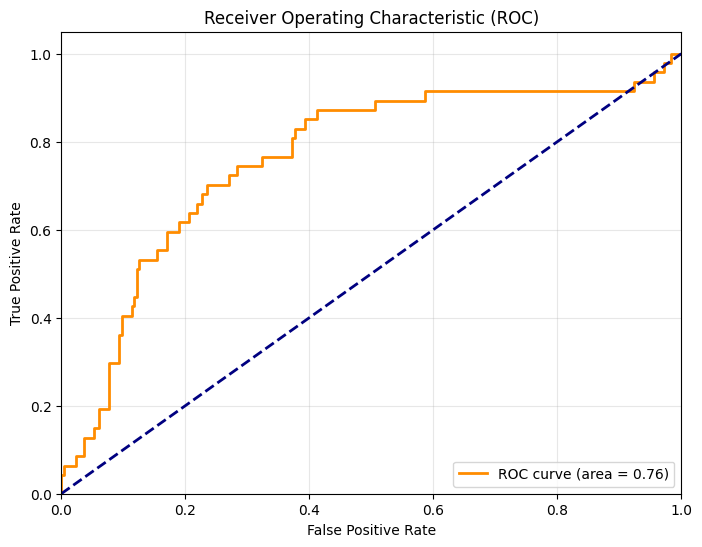

In [31]:
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_prob)

## 7. Saving the Model


In [81]:
# Save the model
import joblib
import os

os.makedirs("../models", exist_ok=True)
model_path = "../models/random_forest_model.joblib"
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/random_forest_model.joblib


## 7. Brief Feature Importance Check

Before diving into deep XAI (SHAP/LIME), let's look at the model's native feature importance.


C:\Users\Gomi\AppData\Local\Temp\ipykernel_25376\1316153036.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp.head(15), y=feature_imp.head(15).index, palette="viridis")


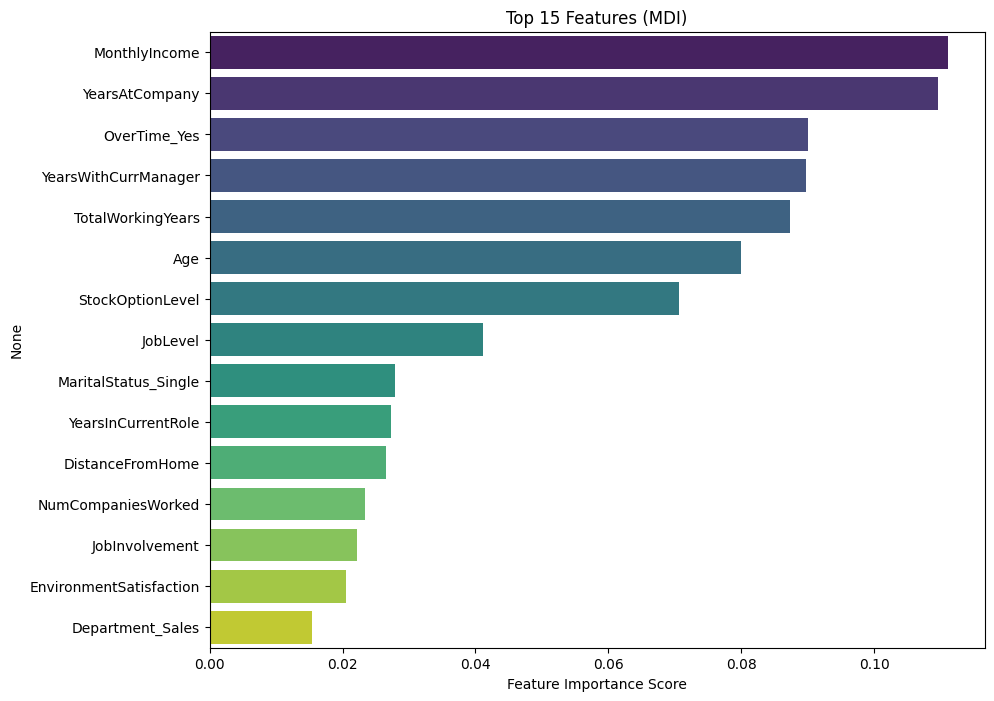

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.Series(
    rf_model.feature_importances_, index=X_encoded.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_imp.head(15), y=feature_imp.head(15).index, palette="viridis")
plt.title("Top 15 Features (MDI)")
plt.xlabel("Feature Importance Score")
plt.show()

## Next Steps

Now that we have a trained model with decent performance (check Recall for class 1), we can proceed to:

1.  **Global XAI:** Apply Permutation Importance and SHAP Summary.
2.  **Local XAI:** Analyze specific false negatives.
